<a href="https://colab.research.google.com/github/jose-montesinosp-um-es/bases2/blob/main/pr/bd2-sesion7-cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

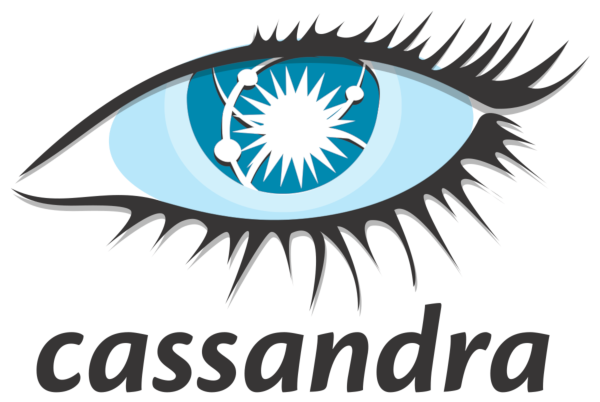

Esta hoja muestra cómo acceder a bases de datos Cassandra y también a conectar la salida con Jupyter.

Con Cassandra vamos a simular un modo semi-clúster con una sola máquina.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [2]:
if not RunningInCOLAB:
    !sudo apt-get update -qq
    !sudo apt-get install -y -qq gpg default-jdk p7zip

In [3]:
# Search for the first java interpreter. This code should work. If not, adjust JAVA_HOME manually.
import os
from pathlib import Path

def find_java_home() -> str | None:
  p  = Path('/usr/lib/jvm')
  (_, dirs, _) = next(os.walk(p))
  for d in dirs:
    inner_java: Path = p / d / 'bin' / 'java'
    if inner_java.is_file() and inner_java.stat().st_mode & 0o111:
        return str(p.joinpath(d).absolute())
  return None

JAVA_HOME: str | None = os.getenv('JAVA_HOME', find_java_home())

In [4]:
%env JAVA_HOME=$JAVA_HOME

env: JAVA_HOME=/usr/lib/jvm/java-1.11.0-openjdk-amd64


## Instalación de Apache Cassandra

Descargamos el ejecutable comprimido desde su página oficial

In [5]:
# Determinar qué versión 5.x.x de Cassandra es la más reciente.
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
from re import Pattern

version_re: Pattern = re.compile(r'^(5\.[0-9]+(\.[0-9]+)?)')
req = Request("https://dlcdn.apache.org/cassandra/")
html_page = urlopen(req)

soup = BeautifulSoup(html_page)
bigger5x: str = max(*[m.group(0) for m in [version_re.match(link.get_text()) for link in soup.find_all('a')] if m],
                       '5.0.0') # Base version 5.x.x

In [6]:
%env CASSANDRA_VER=$bigger5x

env: CASSANDRA_VER=5.0.3


Descarga de Cassandra y de su firma digital SHA256 para comprobar que el fichero es correcto.

In [7]:
!wget https://dlcdn.apache.org/cassandra/${CASSANDRA_VER}/apache-cassandra-${CASSANDRA_VER}-bin.tar.gz
!wget https://dlcdn.apache.org/cassandra/${CASSANDRA_VER}/apache-cassandra-${CASSANDRA_VER}-bin.tar.gz.sha256

--2025-04-03 09:31:01--  https://dlcdn.apache.org/cassandra/5.0.3/apache-cassandra-5.0.3-bin.tar.gz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70338633 (67M) [application/x-gzip]
Saving to: ‘apache-cassandra-5.0.3-bin.tar.gz’

apache-cassandra-5. 100%[===================>]  67.08M   257MB/s    in 0.3s    

2025-04-03 09:31:01 (257 MB/s) - ‘apache-cassandra-5.0.3-bin.tar.gz’ saved [70338633/70338633]

--2025-04-03 09:31:01--  https://dlcdn.apache.org/cassandra/5.0.3/apache-cassandra-5.0.3-bin.tar.gz.sha256
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘apache-cassandra-5.0.3-bin.tar.gz.sha256’

apache-cassandra-5. 100%[==

Comprobamos que la firma coincide con el fichero descargado.

In [8]:
%%sh
gpg --print-md SHA256 < apache-cassandra-${CASSANDRA_VER}-bin.tar.gz \
    | tr A-F a-f | tr -d ' ' \
    | diff -q apache-cassandra-${CASSANDRA_VER}-bin.tar.gz.sha256 - || echo "No coinciden!"

gpg: directory '/root/.gnupg' created
gpg: keybox '/root/.gnupg/pubring.kbx' created


Dependiendo de la versión de Java, hay que ejecutar Cassandra con un parámetro adicional.

In [9]:
javav = !javap -verbose java.lang.String | grep "major version" | cut -d ' ' -f 5
cassandra_opts: str = ""
if int(javav[0]) > 55:
    cassandra_opts = "-Djava.security.manager=allow"

In [10]:
%env CASSANDRA_OPTS=$cassandra_opts

env: CASSANDRA_OPTS=


Descomprimimos el archivo descargado:

In [11]:
!tar xzf apache-cassandra-${CASSANDRA_VER}-bin.tar.gz && echo OK!

OK!


Hay que cambiar cuestiones de la configuracion de Cassandra para permitir *batches* más grandes:

In [12]:
%%sh
sed -i -e "s/\(tombstone_failure_threshold:\).*/\\1 1000000/;s/\(batch_size_warn_threshold:\).*/\\1 128KiB/;s/\(batch_size_fail_threshold:\).*/\\1 1024KiB/" apache-cassandra-${CASSANDRA_VER}/conf/cassandra.yaml

Arracamos la base de datos (el parámetro `-f` ejecuta el servidor en segundo plano).

In [13]:
!(cd apache-cassandra-${CASSANDRA_VER}/ && sudo bin/cassandra -R ${CASSANDRA_OPTS})

CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.deserializeLargeSubset(Lorg/apache/cassandra/io/util/DataInputPlus;Lorg/apache/cassandra/db/Columns;I)Lorg/apache/cassandra/db/Columns;
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubset(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;ILorg/apache/cassandra/io/util/DataOutputPlus;)V
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubsetSize(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;I)I
CompileCommand: dontinline org/apache/cassandra/db/commitlog/AbstractCommitLogSegmentManager.advanceAllocatingFrom(Lorg/apache/cassandra/db/commitlog/CommitLogSegment;)V
CompileCommand: dontinline org/apache/cassandra/db/transform/BaseIterator.tryGetMoreContents()Z
CompileCommand: dontinline org/apache/cassandra/db/transform/StoppingTransformation.stop()V
CompileCommand: dontinline org/apache/cassandra/db/transform/StoppingTransformation.s

Con el comando `nodetool status` podemos ver que nuestro cluster contiene un unico datacenter, con un único host. Hacemos un bucle para esperar hasta que esté disponible, porque la inicialización lleva un tiempo.

In [14]:
%%sh
until apache-cassandra-${CASSANDRA_VER}/bin/nodetool status | grep -q 'UN'; do
    sleep 5
done

Si quisieramos abrir la shell de comandos de Cassandra para ejecutar instrucciones directamente sobre ella deberíamos ejecutar el siguiente comando.

*De todas formas, dejamos la celda comentada puesto que nuestro interés es en acceder a la BD mediante Python*

In [15]:
#!apache-cassandra-${CASSANDRA_VER}/bin/cqlsh

## Acceso a Cassandra mediante Python

Instalamos la librería `cassandra-driver` que nos dará acceso a nuestra instancia de Cassandra.

In [16]:
%pip install --upgrade cassandra-driver pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Nos conectamos al cluster de la BBDD especificando un único *host*. Cassandra verá el resto de *hosts* del clúster.

In [17]:
from cassandra.cluster import Cluster, Session, ExecutionProfile
from cassandra.query import named_tuple_factory
import os

node1_profile = ExecutionProfile(row_factory=named_tuple_factory) # Se utiliza el modo "named tuple"
#node2_profile = ...

profiles: dict[str, ExecutionProfile] = {'node1': node1_profile,
            # 'node2': node2_profile
            }
cluster = Cluster(contact_points=[os.getenv('DB_HOSTNAME', '127.0.0.1')],
                     execution_profiles=profiles)
session: Session = cluster.connect()

Listamos el conjunto de nodos:

In [18]:
hosts = cluster.metadata.all_hosts()
nhosts: int = len(hosts)
hosts

[<Host: 127.0.0.1:9042 datacenter1>]

In [19]:
local_query = 'SELECT rpc_address FROM system.local'
for _ in cluster.metadata.all_hosts():
    print(session.execute(local_query).one())

Row(rpc_address='127.0.0.1')


### Creación de espacios de nombres y tablas

Vamos a crear ahora un `keyspace` llamado `ciclismo` que vamos a usar posteriormente para definir una tabla sobre ciclistas.

In [20]:
from cassandra.cluster import ResultSet

resultado: ResultSet = session.execute("""
    CREATE KEYSPACE IF NOT EXISTS ciclismo
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': %d}
""" % (nhosts))

print(resultado)

Vamos ahora a crear una tabla `ciclistas`.

In [21]:
session.execute("""CREATE TABLE IF NOT EXISTS ciclismo.ciclistas (
  id int,
  nombre text,
  apellidos text,
  edad int,
  equipo text,
  pais text,
  fecha_alta date,
  PRIMARY KEY (id));
  """);

### Inserción de datos

Vamos ahora a insertar 20 ciclistas sobre la base de datos con la instruccion `INSERT INTO`.

*¿Cuantos personajes de películas conoces? :-P*

In [22]:
from datetime import date

# Lista de datos de ejemplo para inserción
data: list[tuple] = [
    (1, 'Luke', 'Skywalker', 25, 'Rebels', 'Tatooine', date(1980, 5, 25)),
    (2, 'Leia', 'Organa', 23, 'Rebels', 'Alderaan', date(1977, 5, 25)),
    (3, 'Han', 'Solo', 30, 'Rebels', 'Corellia', date(1977, 5, 25)),
    (4, 'Indiana', 'Jones', 35, 'Archaeologists', 'USA', date(1981, 6, 12)),
    (5, 'Ellen', 'Ripley', 30, 'Weyland-Yutani', 'USA', date(1979, 5, 25)),
    (6, 'Marty', 'McFly', 17, 'Hill Valley High School', 'USA', date(1985, 7, 3)),
    (7, 'Doc', 'Brown', 65, 'Scientist', 'USA', date(1985, 7, 3)),
    (8, 'Sarah', 'Connor', 29, 'Resistance', 'USA', date(1984, 10, 26)),
    (9, 'John', 'Connor', 10, 'Resistance', 'USA', date(1991, 7, 3)),
    (10, 'Hermione', 'Granger', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (11, 'Harry', 'Potter', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (12, 'Ron', 'Weasley', 17, 'Gryffindor', 'UK', date(1997, 6, 26)),
    (13, 'Neo', '', 30, 'The One', 'Unknown', date(1999, 3, 31)),
    (14, 'Trinity', '', 27, 'The One', 'Unknown', date(1999, 3, 31)),
    (15, 'Morpheus', '', 45, 'The One', 'Unknown', date(1999, 3, 31)),
    (16, 'Fox', 'Mulder', 35, 'FBI', 'USA', date(1993, 9, 10)),
    (17, 'Dana', 'Scully', 32, 'FBI', 'USA', date(1993, 9, 10)),
    (18, 'Ross', 'Geller', 30, 'Paleontologist', 'USA', date(1994, 9, 22)),
    (19, 'Rachel', 'Green', 29, 'Fashion', 'USA', date(1994, 9, 22)),
    (20, 'Chandler', 'Bing', 29, 'Advertising', 'USA', date(1994, 9, 22))
]

# Insertar los datos en la tabla ciclistas
for row in data:
    session.execute(
        """
        INSERT INTO ciclismo.ciclistas (id, nombre, apellidos, edad, equipo, pais, fecha_alta)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        """,
        row
    );

print("Se han insertado las filas correctamente.")

Se han insertado las filas correctamente.


### Creación de índices

Vamos a crear diferentes índices secundarios sobre algunos de los campos que hemos definido en la tabla `ciclistas`.

In [23]:
session.execute("""
  CREATE CUSTOM INDEX idx_nombre ON ciclismo.ciclistas(nombre)
  USING 'StorageAttachedIndex';
  """)

session.execute("""
  CREATE CUSTOM INDEX idx_edad ON ciclismo.ciclistas(edad)
  USING 'StorageAttachedIndex';
  """)

session.execute("""
  CREATE CUSTOM INDEX idx_apellidos ON ciclismo.ciclistas(apellidos)
  USING 'StorageAttachedIndex';
  """)

session.execute("""
  CREATE CUSTOM INDEX idx_pais ON ciclismo.ciclistas(pais)
  USING 'StorageAttachedIndex';
  """)

### Consultas de selección

Vamos ahora a lanzar algunas consultas para hacer determinadas búsquedas sobre la base de datos.

En primer lugar, vamos a seleccionar todos los ciclistas cuyo nombre sea "Luke".

In [24]:
query1 = "SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Luke';"
print("Ejecutando consulta 1:", query1)
try:
    rows1: ResultSet = session.execute(query1)
    for row in rows1:
        print(row)
except Exception as e:
    print(e)

Ejecutando consulta 1: SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Luke';
Row(id=1, apellidos='Skywalker', edad=25, equipo='Rebels', fecha_alta=Date(3797), nombre='Luke', pais='Tatooine')


Vamos ahora a seleccionar todos los ciclistas cuyos `apellidos` sean Solo.

In [25]:
query2 = "SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'Solo';"
print("Ejecutando consulta 2:", query2)
rows2: ResultSet = session.execute(query2)
for row in rows2:
    print(row)

Ejecutando consulta 2: SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'Solo';
Row(id=3, apellidos='Solo', edad=30, equipo='Rebels', fecha_alta=Date(2701), nombre='Han', pais='Corellia')


Ahora seleccionamos todos los ciclistas cuyo `pais` sea "USA".

In [26]:
query3 = "SELECT * FROM ciclismo.ciclistas WHERE pais = 'USA';"
print("Ejecutando consulta 3:", query3)
rows3: ResultSet = session.execute(query3)
for row in rows3:
    print(row)

Ejecutando consulta 3: SELECT * FROM ciclismo.ciclistas WHERE pais = 'USA';
Row(id=5, apellidos='Ripley', edad=30, equipo='Weyland-Yutani', fecha_alta=Date(3431), nombre='Ellen', pais='USA')
Row(id=16, apellidos='Mulder', edad=35, equipo='FBI', fecha_alta=Date(8653), nombre='Fox', pais='USA')
Row(id=19, apellidos='Green', edad=29, equipo='Fashion', fecha_alta=Date(9030), nombre='Rachel', pais='USA')
Row(id=8, apellidos='Connor', edad=29, equipo='Resistance', fecha_alta=Date(5412), nombre='Sarah', pais='USA')
Row(id=4, apellidos='Jones', edad=35, equipo='Archaeologists', fecha_alta=Date(4180), nombre='Indiana', pais='USA')
Row(id=18, apellidos='Geller', edad=30, equipo='Paleontologist', fecha_alta=Date(9030), nombre='Ross', pais='USA')
Row(id=20, apellidos='Bing', edad=29, equipo='Advertising', fecha_alta=Date(9030), nombre='Chandler', pais='USA')
Row(id=7, apellidos='Brown', edad=65, equipo='Scientist', fecha_alta=Date(5662), nombre='Doc', pais='USA')
Row(id=6, apellidos='McFly', edad=

Intentemos ahora seleccionar todos los ciclistas cuya edad sea mayor que 30.

In [27]:
query4 = "SELECT * FROM ciclismo.ciclistas WHERE edad > 30"
print("Ejecutando consulta 4:", query4)
try:
    rows4: ResultSet = session.execute(query4)
    for row in rows4:
        print(row)
except Exception as e:
    print(e)

Ejecutando consulta 4: SELECT * FROM ciclismo.ciclistas WHERE edad > 30
Row(id=16, apellidos='Mulder', edad=35, equipo='FBI', fecha_alta=Date(8653), nombre='Fox', pais='USA')
Row(id=4, apellidos='Jones', edad=35, equipo='Archaeologists', fecha_alta=Date(4180), nombre='Indiana', pais='USA')
Row(id=15, apellidos='', edad=45, equipo='The One', fecha_alta=Date(10681), nombre='Morpheus', pais='Unknown')
Row(id=7, apellidos='Brown', edad=65, equipo='Scientist', fecha_alta=Date(5662), nombre='Doc', pais='USA')
Row(id=17, apellidos='Scully', edad=32, equipo='FBI', fecha_alta=Date(8653), nombre='Dana', pais='USA')


Por último, vamos a seleccionar todos los ciclistas cuyo nombre sea "Harry" y su equipo sea "Gryffindor". Para ello, necesitamos acceder a los campos `nombre`, sobre el cual ya definimos el un índice `idx_nombre`, y `equipo`, sobre el cual no hemos definido ningún índice.

Vamos a suponer que esa consulta que queremos lanzar es una _query_ puntual y que no va a repetirse en el tiempo. Por tanto, como ingenieros de datos, no vemos necesario crear un índice sobre `equipo`. Por el contrario, lanzamos la consulta con la clausula `ALLOW FILTERING` que permite lanzar consultas sobre columnas sobre las cuales no hemos definido ningún índice. Esto es necesario porque Cassandra no permite lanzar consultas sobre columnas no indexadas por defecto, ya que podría dar como resultado una consulta de mucha duración.

In [28]:
query5 = "SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Harry' AND equipo = 'Gryffindor' ALLOW FILTERING;"
print("Ejecutando consulta 5:", query5)
rows5: ResultSet = session.execute(query5)
for row in rows5:
    print(row)

Ejecutando consulta 5: SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Harry' AND equipo = 'Gryffindor' ALLOW FILTERING;
Row(id=11, apellidos='Potter', edad=17, equipo='Gryffindor', fecha_alta=Date(10038), nombre='Harry', pais='UK')


### Consultas de Actualización

Es importante destacar que en Cassandra, las actualizaciones deben basarse en la clave primaria (que generalmente incluye la clave de partición).

In [29]:
session.execute("""
  UPDATE ciclismo.ciclistas
  SET equipo = 'HalconMilenario'
  WHERE id = 3;
""")

In [30]:
query2 = "SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'Solo';"
print("Ejecutando consulta 2:", query2)
rows2: ResultSet = session.execute(query2)
for row in rows2:
    print(row)

Ejecutando consulta 2: SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'Solo';
Row(id=3, apellidos='Solo', edad=30, equipo='HalconMilenario', fecha_alta=Date(2701), nombre='Han', pais='Corellia')


### Consultas de borrado

Si solo quieres eliminar una columna específica en lugar de la fila completa, puedes hacerlo usando `DELETE` y especificando la columna.
**Esto no elimina la fila completa, solo la columna indicada**.

In [31]:
session.execute("""
  DELETE equipo FROM ciclismo.ciclistas WHERE id = 6;
""")

Como podemos ver la fila de Martin McFly sigue existiendo en la BD solo que sin la columna `equipo`.

In [32]:
query2 = "SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'McFly';"
print("Ejecutando consulta despues de borrado 1:", query2)
rows2: ResultSet = session.execute(query2)
for row in rows2:
    print(row)

Ejecutando consulta despues de borrado 1: SELECT * FROM ciclismo.ciclistas WHERE apellidos = 'McFly';
Row(id=6, apellidos='McFly', edad=17, equipo=None, fecha_alta=Date(5662), nombre='Marty', pais='USA')


Si quisiera eliminar una fila entera debería ejecutar directamente `DELETE FROM`.

In [33]:
session.execute("""
  DELETE FROM ciclismo.ciclistas WHERE id = 13;
""")

Ahora vemos que el ciclista  `Neo` ya no aparece en la BD.

In [34]:
query2 = "SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Neo';"
print("Ejecutando consulta despues de borrado 2:", query2)
rows2: ResultSet = session.execute(query2)
for row in rows2:
    print(row)

Ejecutando consulta despues de borrado 2: SELECT * FROM ciclismo.ciclistas WHERE nombre = 'Neo';


## Trabajo con los datos de StackOverflow

### Descarga de datos

Descargamos los ficheros de *stackoverflow* para trabajar con ellos en Cassandra.

In [35]:
%%sh
wget -q https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
wget -q https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

In [36]:
%%sh
7zr x es.stackoverflow.csv.7z.001 && rm -rf es.stackoverflow.csv.7z.00?


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 104857600 bytes (100 MiB)

Extracting archive: es.stackoverflow.csv.7z.001
--
Path = es.stackoverflow.csv.7z.001
Type = Split
Physical Size = 104857600
Volumes = 2
Total Physical Size = 200457538
----
Path = es.stackoverflow.csv.7z
Size = 200457538
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

Everything is Ok

Files: 5
Size:       1044736301
Compressed: 200457538


### Creación de espacios de nombres y tablas

Vamos a crear ahora un `keyspace` llamado `stackoverflow` que vamos a usar posteriormente para definir las tablas necesarias.

In [37]:
from cassandra.cluster import ResultSet

resultado: ResultSet = session.execute("""
    CREATE KEYSPACE IF NOT EXISTS stackoverflow
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': %d}
""" % (nhosts))

print(resultado.one())

None


Se utiliza ese *keyspace* a partir de ahora.

In [38]:
session.execute("USE stackoverflow");

### Tablas `Questions` y `Answers`

A continuación vamos a crear las tablas `Questions` y `Answers`. ¿Por qué antes teníamos sólo una tabla y ahora creamos dos?

El funcionamiento de Cassandra es diferente al de un SQL tradicional. Aunque el CQL es similar a SQL, tiene unas restricciones, como por ejemplo, que no puede utilizar funciones de agregación (`MAX`, `AVG`, etc.) ni `JOIN`s. Por eso, en este caso tomamos esta decisión. La explicaremos mejor después.

En la tabla `Questions` vamos a almacenar las preguntas y en la tabla `Answers` las respuestas. La relación entre ambas tablas es de uno a muchos, es decir, una pregunta puede tener muchas respuestas, pero una respuesta sólo puede pertenecer a una pregunta. Por lo tanto, la clave primaria de la tabla `Answers` será la combinación de `ParentId`, `CreationDate` (para ordenación) e `Id` (para distinguir dos respuestas que por casualidad se hayan producido en el mismo milisegundo).

In [39]:
session.execute("""
CREATE TABLE IF NOT EXISTS stackoverflow.Questions (
    Id BIGINT,
    AcceptedAnswerId BIGINT,
    AnswerCount INT,
    Body TEXT,
    ClosedDate TIMESTAMP,
    CommentCount INT,
    CommunityOwnedDate TIMESTAMP,
    ContentLicense TEXT,
    CreationDate TIMESTAMP,
    FavoriteCount INT,
    LastActivityDate TIMESTAMP,
    LastEditDate TIMESTAMP,
    LastEditorDisplayName TEXT,
    LastEditorUserId BIGINT,
    OwnerDisplayName TEXT,
    OwnerUserId BIGINT,
    -- ParentId BIGINT,
    -- PostTypeId BIGINT, -- 1 = Question, 2 = Answer
    Score BIGINT,
    Tags TEXT,
    Title TEXT,
    ViewCount BIGINT,
    PRIMARY KEY(Id, CreationDate)
) WITH compression = {'class': 'LZ4Compressor'}
  AND CLUSTERING ORDER BY (CreationDate ASC);
""");

In [40]:
from cassandra.query import PreparedStatement, BatchStatement
from cassandra import ConsistencyLevel
import pandas as pd

def csv_to_cassandra(chunk: pd.DataFrame, statement: PreparedStatement, session: Session, table: str) -> None:
    """
    Carga un array de datos en una tabla de Cassandra.
    """
    counter: int = 0
    batch = BatchStatement(consistency_level=ConsistencyLevel.ANY)

    for _,row in chunk.iterrows():
        counter += 1
        batch.add(statement, row.values)
        if counter % 20 == 0:
            session.execute(batch)
            batch.clear()

    if batch:
        session.execute(batch)
        batch.clear()

Como la inserción tarda mucho (unos 7 minutos), lo hacemos de una forma que puede causar en algún caso una falta de memoria (aquí no sucede). Cargamos primero los datos en memoria en un `DataFrame` de Pandas, lo partimos en varios trozos e insertamos en la BD en paralelo.

In [41]:
import pandas as pd
import numpy as np

df_posts: pd.DataFrame = pd.read_csv('Posts.csv', encoding='utf-8', header=0,
                 dtype={'Id': 'Int64', 'PostTypeId': 'Int64', 'AcceptedAnswerId': 'Int64', 'ParentId': 'Int64',
                        'Score': 'Int64', 'ViewCount': 'Int64',
                        'Body': pd.StringDtype(), 'OwnerUserId': 'Int64', 'OwnerDisplayName': pd.StringDtype(),
                        'LastEditorUserId': 'Int64', 'LastEditorDisplayName': pd.StringDtype(),
                        'Title': pd.StringDtype(), 'Tags': pd.StringDtype(), 'AnswerCount': 'Int64',
                        'CommentCount': 'Int64', 'FavoriteCount': 'Int64',
                        'ContentLicense': pd.StringDtype()},
                 parse_dates=['CreationDate','LastEditDate','LastActivityDate','ClosedDate','CommunityOwnedDate'])

df_posts = df_posts.replace({np.nan: None}) # Solventar algunos problemas con la importación

In [42]:
df_posts

,Id,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,1,2,1,<p>Estoy creando un servicio usando <em>ASP.NE...,None,2,None,CC BY-SA 4.0,2015-10-29 15:56:52.933000,None,...,user13558,None,None,23,None,1,40,<.net><asp.net-web-api><asp.net>,La creación manual de un alias de ruta con un ...,780
1,2,None,None,<p>He encontrado la solución.</p><br/><br/><p>...,None,2,None,CC BY-SA 3.0,2015-10-29 19:14:23.673000,None,...,None,None,None,23,1,2,31,None,None,None
2,3,9,3,"<p>Luego de ver cierto código, me he dado cuen...",None,1,None,CC BY-SA 3.0,2015-10-29 23:54:31.947000,None,...,None,20,None,21,None,1,20,<delphi>,¿Es igual utilizar .AsString que .Text para ob...,1035
3,4,None,None,"<p><code>.AsString</code> devuelve el mismo ""<...",None,0,None,CC BY-SA 3.0,2015-10-30 00:45:47.640000,None,...,None,25,None,24,3,2,6,None,None,None
4,5,208,7,<p>¿Cuál es la forma más eficiente de separar ...,None,1,None,CC BY-SA 3.0,2015-10-30 01:15:27.267000,None,...,None,729,None,24,None,1,37,<c++><string>,¿Cómo separar las palabras que contiene un str...,37867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410341,609180,None,0,<p>Hola estoy tratando de ejecutar una barra d...,None,1,None,CC BY-SA 4.0,2023-12-03 03:04:16.347000,None,...,None,822,None,345631,None,1,0,<javascript><php>,hola_voy_acrearuna_barra_de_progreso_con mysql,19
410342,609181,None,0,"<p><a href=""https://i.stack.imgur.com/T3LwA.pn...",None,0,None,CC BY-SA 4.0,2023-12-03 03:16:02.617000,None,...,None,None,None,290910,None,1,0,<nodejs><npm>,como se soluciono el npm ERR! code ENOENT,2
410343,609182,None,0,"<p>somos un equipo universitarios, necesitamos...",None,2,None,CC BY-SA 4.0,2023-12-03 04:20:00.530000,None,...,None,345634,None,345634,None,1,0,<c++><array><ordenamiento><recursión><ordenar>,¿Como puedo hacer que un valor int que esta en...,14
410344,609183,None,0,<p>estoy en Windows 10 y tengo Geany en la ver...,None,0,None,CC BY-SA 4.0,2023-12-03 04:22:52.590000,None,...,None,None,None,263358,None,1,0,<c++><gdb>,Problema con la depuración en geany: el sistem...,7


In [43]:
from concurrent.futures import ThreadPoolExecutor, Future
import numpy as np

def background_import(df: pd.DataFrame, session: Session, stmt: PreparedStatement, table: str) -> list[Future[None]]:
    """Importa en segundo plano un DataFrame a una tabla de Cassandra.

    Args:
        df (pd.DataFrame): _description_
        function (Callable[[pd.DataFrame, Session, str], None]): _description_
        table (str): _description_

    Returns:
        list[Future[None]]: _description_
    """
    background_processes: int = max(4, (os.cpu_count() or 0) - 1)
    batches: list[pd.DataFrame] = np.array_split(df, indices_or_sections=background_processes)
    e = ThreadPoolExecutor(background_processes)
    result: list[Future[None]] = list(map(lambda batch: e.submit(csv_to_cassandra,
                                                                 batch,
                                                                 stmt,
                                                                 session,
                                                                 table),
                                          batches))
    return result


In [44]:
def background_import_questions(df_posts: pd.DataFrame, session: Session, table: str) -> list[Future[None]]:
    insert_question_stmt: PreparedStatement = session.prepare(f"""
        INSERT INTO {table} (
            Id, AcceptedAnswerId, AnswerCount, Body, ClosedDate,
            CommentCount, CommunityOwnedDate, ContentLicense, CreationDate,
            FavoriteCount, LastActivityDate, LastEditDate,
            LastEditorDisplayName, LastEditorUserId,
            OwnerDisplayName, OwnerUserId,
            Score, Tags, Title, ViewCount)
        VALUES (?, ?, ?, ?, ?,
                ?, ?, ?, ?,
                ?, ?, ?,
                ?, ?, ?, ?,
                ?, ?, ?, ?);
        """)
    df_to_insert: pd.DataFrame = df_posts[df_posts['PostTypeId'] == 1].drop(columns=['PostTypeId', 'ParentId'])
    return background_import(df_to_insert,
                             session,
                             insert_question_stmt,
                             table)

future_questions: list[Future[None]] = background_import_questions(df_posts, session, 'stackoverflow.Questions')

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [46]:
list(map(Future.running, future_questions))

[False, False, False, False]

In [47]:
from concurrent.futures import wait
# Si no se está en interactivo, espera a que termine la importación.
if not RunningInCOLAB:
    # wait for all futures in future_questions
    wait(future_questions, timeout=300, return_when='ALL_COMPLETED')

Se muestra un ejemplo de consulta. Nótese que como las preguntas se buscan por `Id`, el índice creado para la tabla, y su consiguiente almacenamiento, es correcto.

In [48]:
from cassandra.cluster import ResultSet
result: ResultSet = session.execute("""
    SELECT Id, CreationDate, Title, Body, AnswerCount
    FROM stackoverflow.Questions
    WHERE Id = 3
""")

for row in result:
    print(row.id, row.creationdate, row.title)
    print(f"Número de respuestas: {row.answercount}")
    print("Texto de la pregunta:")
    print(row.body)
    print("...")

3 2015-10-29 23:54:31.947000 ¿Es igual utilizar .AsString que .Text para obtener el valor de un campo de un DataSet?
Número de respuestas: 3
Texto de la pregunta:
<p>Luego de ver cierto código, me he dado cuenta que utilizan este estilo:</p><br/><br/><pre><code>aStr:=tblAcct.FieldByName('Name').Text;<br/></code></pre><br/><br/><p>Parece trabajar bien, pero yo había utilizado hasta ahora:</p><br/><br/><pre><code>aStr:=tblAcct.FieldByName('Name').AsString;<br/></code></pre><br/><br/><p>He utilizado ambos al cargar un TMemo y no parece haber diferencia alguna.</p><br/><br/><pre><code>aMemo.Lines.Text:=tblAcct.FieldByName('History').Text;<br/>aMemo.Lines.Text:=tblAcct.FieldByName('History').AsString;<br/></code></pre><br/><br/><p>¿Hay alguna razón por la que deba utilizar una y no la otra? ¿Cuál es esa razón?</p><br/><br/><p>Normalmente, para un memo, utilizo:</p><br/><br/><pre><code>aMemo.Lines.Assign(tblAcct.FieldByName('History'))<br/></code></pre><br/><br/><p>Y esto trabaja bien tambié

Vamos ahora a crear la tabla de respuestas (`Answers`). En este caso, la clave primaria es la combinación de `ParentId` (la pregunta a la que hace referencia), su `CreationDate` como clave de ordenación y su ID `Id`, ya que una pregunta puede tener muchas respuestas, y además las consultas siempre obtienen las respuestas cuando se busca la pregunta. Haciendo la clave de partición dependiente del ID de la pregunta hacemos que todas las respuestas estén juntas en la misma *wide column*, acelerando las consultas.

In [49]:
session.execute("""
CREATE TABLE IF NOT EXISTS stackoverflow.Answers (
    Id BIGINT,
    -- AcceptedAnswerId BIGINT,
    -- AnswerCount INT,
    Body TEXT,
    -- ClosedDate TIMESTAMP,
    CommentCount INT,
    CommunityOwnedDate TIMESTAMP,
    ContentLicense TEXT,
    CreationDate TIMESTAMP,
    FavoriteCount INT,
    LastActivityDate TIMESTAMP,
    LastEditDate TIMESTAMP,
    LastEditorDisplayName TEXT,
    LastEditorUserId BIGINT,
    OwnerDisplayName TEXT,
    OwnerUserId BIGINT,
    ParentId BIGINT,
    -- PostTypeId BIGINT, -- 1 = Question, 2 = Answer
    Score BIGINT,
    -- Tags TEXT,
    -- Title TEXT,
    ViewCount BIGINT,
    PRIMARY KEY(ParentId, CreationDate, Id)
) WITH compression = {'class': 'LZ4Compressor'}
  AND CLUSTERING ORDER BY (CreationDate ASC);
""");

Al igual que antes, usamos un futuro porque la inserción tarda mucho (unos 8 minutos). Mientras tanto podemos hacer la siguiente consulta.

In [50]:
def background_import_answers(df_posts: pd.DataFrame, session: Session, table: str) -> list[Future[None]]:
    insert_answer_stmt: PreparedStatement = session.prepare(f"""
        INSERT INTO {table} (Id, Body, CommentCount,
            CommunityOwnedDate, ContentLicense, CreationDate,
            FavoriteCount, LastActivityDate, LastEditDate,
            LastEditorDisplayName, LastEditorUserId,
            OwnerDisplayName, OwnerUserId, ParentId,
            Score, ViewCount)
        VALUES (?, ?, ?,
                ?, ?, ?,
                ?, ?, ?,
                ?, ?,
                ?, ?, ?,
                ?, ?);
        """)
    df_to_insert: pd.DataFrame = df_posts[df_posts['PostTypeId'] == 2]\
        .drop(columns=['AnswerCount', 'AcceptedAnswerId', 'ClosedDate', 'PostTypeId', 'Tags', 'Title'])
    return background_import(df_to_insert,
                             session,
                             insert_answer_stmt,
                             table)

future_answers: list[Future[None]] = background_import_answers(df_posts, session, 'stackoverflow.Answers')

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [53]:
list(map(Future.running, future_answers))

[False, False, False, False]

In [52]:
from concurrent.futures import wait
# Si no se está en interactivo, espera a que termine la importación.
if not RunningInCOLAB:
    # wait for all futures in future_questions
    wait(future_answers, timeout=300, return_when='ALL_COMPLETED')

Si antes vimos la pregunta 3, podemos ver las respuestas de la pregunta 3. Con la especificación de claves, todas las respuestas de una pregunta pertenecen a la misma *wide column*, por lo que se pueden recuperar todas las respuestas de una pregunta en una sola consulta. Esto es lo que se llama un *wide row*.

In [54]:
result: ResultSet = session.execute("""
    SELECT ParentId, Id, CreationDate, Body, Score
    FROM stackoverflow.Answers
    WHERE ParentId = 3
""")
for row in result:
    print(row.id, row.creationdate, row.parentid, row.score)
    print(row.body)
    print("...")


4 2015-10-30 00:45:47.640000 3 6
<p><code>.AsString</code> devuelve el mismo "<em>string</em>" que la propiedad <code>.Text</code> si no existe ningún controlador de eventos "Event Handler", <code>OnGetText</code>, pero de existir uno puede darse el caso de ser diferente, o quizás un descendiente en <code>TField</code> que no sea el estándar podría ocasionar que fuera diferente.</p><br/><br/><p>Saludos y espero ayude.</p><br/><br/><p>P.D: Sobre si hay una razón para usar una u otra no sabría decirle con total certeza eso dependería del uso que tenga previsto para el valor de retorno.</p><br/>
...
9 2015-10-30 13:59:47.113000 3 12
<p>Antes de responder directamente la respuesta, hablaremos de las propiedades relevantes de TField y sus descendientes.</p><br/><br/><h1><code>Text</code>/<code>DisplayText</code></h1><br/><br/><p>Ambas propiedades sirven para obtener una representación textual del valor del campo para su uso en la Interfaz de Usuario. <br/>El propósito de la propiedad <code>

### Tabla `Users`

Vamos a crear la tabla `Users`. En este caso, la clave primaria es el `Id` del usuario. La consulta se hace por `Id`, por lo que no es necesario crear un índice adicional.


In [55]:
# Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
session.execute("""
CREATE TABLE IF NOT EXISTS stackoverflow.Users (
    Id BIGINT,
    AboutMe TEXT,
    AccountId BIGINT,
    CreationDate TIMESTAMP,
    DisplayName TEXT,
    DownVotes BIGINT,
    LastAccessDate TIMESTAMP,
    Location TEXT,
    Reputation BIGINT,
    UpVotes BIGINT,
    Views BIGINT,
    WebsiteUrl TEXT,
    PRIMARY KEY(Id)
) WITH compression = {'class': 'LZ4Compressor'};
""");

De nuevo, lo cargamos en un `DataFrame` de Pandas y lo insertamos en la BD en paralelo.

In [56]:
# Write the df dataframe to parquet file
df_users: pd.DataFrame = pd.read_csv('Users.csv', encoding='utf-8', header=0,
                 dtype={'Id': 'Int64',
                        'DisplayName': pd.StringDtype(),
                        'Location' : pd.StringDtype(),
                        'UpVotes' : 'Int64',
                        'AboutMe' : pd.StringDtype(),
                        'Reputation' : 'Int64',
                        'AccountId' : 'Int64',
                        'DownVotes': 'Int64',
                        'WebsiteUrl' : pd.StringDtype(),
                        'Views' : 'Int64'},
                 parse_dates=['CreationDate','LastAccessDate'])
df_users.replace({np.nan: None}, inplace=True) # Solventar algunos problemas con la importación

In [57]:
df_users

,Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
0,-1,"<p>Hola, no soy una persona real.</p><br/><br/...",-1,2015-10-26 21:36:24.767,Comunidad,22504,2015-10-26 21:36:24.767,en la granja de servidores,1,10211,2516,None
1,1,<p>Dev #2 who helped create Stack Overflow cur...,2,2015-10-26 22:50:12.710,Geoff Dalgas,0,2021-01-05 19:45:26.807,"Corvallis, OR",101,0,2917,http://stackoverflow.com
2,2,"<p>developer, techie, nerd.... ex-DBRE at Stac...",188123,2015-10-26 22:51:07.007,Taryn,0,2020-08-18 17:39:10.693,Arizona,101,0,109,https://tarynpivots.com
3,3,<p>Topics you might be interested in reading a...,1083,2015-10-26 22:52:12.923,Jon 'links in bio' Ericson,0,2023-06-04 23:58:02.373,Downtown Burbank,101,0,87,https://jlericson.com/
4,4,<p>Lover of all things sharp including pencils...,6254215,2015-10-26 23:18:40.547,Juan M,0,2022-02-11 16:07:18.457,Behind the Glass,101,56,260,None
...,...,...,...,...,...,...,...,...,...,...,...,...
319530,345638,None,30052285,2023-12-03 04:55:59.167,Raen Norjan,0,2023-12-03 05:42:06.350,None,1,0,0,None
319531,345639,None,30052395,2023-12-03 05:26:37.197,Paulina,0,2023-12-03 05:26:37.197,None,1,0,0,None
319532,345640,None,30052406,2023-12-03 05:30:18.450,Orlando BACHELOT BELEÑO,0,2023-12-03 05:30:18.450,None,1,0,0,None
319533,345641,None,30052511,2023-12-03 05:57:07.153,Jocelyn Neponuseno,0,2023-12-03 05:57:07.153,None,1,0,0,None


In [58]:
def background_import_users(df_users: pd.DataFrame, session: Session, table: str) -> list[Future[None]]:
    insert_user_stmt: PreparedStatement = session.prepare(f"""
        INSERT INTO {table} (Id, AboutMe, AccountId,
            CreationDate, DisplayName, DownVotes,
            LastAccessDate, Location, Reputation,
            UpVotes, Views, WebsiteUrl)
        VALUES (?, ?, ?,
                ?, ?, ?,
                ?, ?, ?,
                ?, ?, ?
                );
        """)
    return background_import(df_users,
                             session,
                            insert_user_stmt,
                            'stackoverflow.Users')

future_users: list[Future[None]] = background_import_users(df_users, session, 'stackoverflow.Users')

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [59]:
list(map(Future.running,future_users))

[True, True, True, True]

In [60]:
if not RunningInCOLAB:
    wait(future_users, timeout=300, return_when='ALL_COMPLETED')

In [61]:
users_result: ResultSet = session.execute("""
    SELECT Id, CreationDate, DisplayName, Reputation
    FROM stackoverflow.Users
    WHERE Id = 1
""")
for row in users_result:
    print(row.id, row.creationdate, row.displayname)
    print(f"Reputación: {row.reputation}")
    print("...")

1 2015-10-26 22:50:12.710000 Geoff Dalgas
Reputación: 101
...


## Ejercicios

### Ejercicio 1: Uso de estructuras de datos

Crea una tabla `TagQuestions` que contenga el `Id` de cada pregunta (tabla `Questions`) que contenga un tag en concreto. Usad para ello la construcción *lista* vista en teoría. Para ello tenemos que recorrer todas las Questions, identificar sus tags, y añadir al tag correspondiente.
Crea la tabla con dos columnas que serían `Tag` (TEXT) y `PostList` (LIST\<BIGINT>).
**NOTA: Para acelerar el proceso, usad un mapa en memoria (un diccionario de Python) y luego insertadlo en la BD. Recuerda también que para recorrer toda la tabla `Questions` tienes que usar `ALLOW FILTERING`**.
**Puedes hacer uso de `findall` para localizar los tags.**

In [62]:
session.execute("""
CREATE TABLE IF NOT EXISTS stackoverflow.TagQuestions (
    Tag TEXT,
    PostList LIST<BIGINT>,
    PRIMARY KEY(Tag)
) WITH compression = {'class': 'LZ4Compressor'};
""");

In [63]:
import re
def create_tag_questions_table(session: Session) -> None:
  """ Creamos la table TagQuestions con los Tags y los Ids de las preguntas """

  TagDic: dict[str, list[int]] = {}

  preguntas: ResultSet = session.execute("""
    SELECT Id, Tags
    FROM stackoverflow.Questions
    ALLOW FILTERING
  """)

  for row in preguntas:
    if row.tags is not None:
      tags: list[str] = re.findall(r'<([^>]+)>', row.tags)
      for tag in tags:
        if tag in TagDic:
          TagDic[tag].append(row.id)
        else:
          TagDic[tag] = [row.id]

  insert_tag_stmt: PreparedStatement = session.prepare("""
    INSERT INTO stackoverflow.TagQuestions (Tag, PostList)
    VALUES (?, ?);
  """)

  for tag, ids in TagDic.items():
    session.execute(insert_tag_stmt, (tag, ids))

In [65]:
create_tag_questions_table(session)

El siguiente resultado debe ser correcto:

In [66]:
cassandra_result: ResultSet = session.execute("""
    SELECT Tag, PostList
    FROM stackoverflow.TagQuestions
    WHERE Tag = 'cassandra'
""")
row = cassandra_result.one()

assert row is not None
assert row.tag == 'cassandra'
assert row.postlist == [111656, 346797, 331984, 394051, 120614, 122209, 118284, 336355, 119372, 91771, 78257, 36265, 117046, 92164, 192316, 44020, 412383, 80739]

print(row.tag, row.postlist)

cassandra [111656, 346797, 331984, 394051, 120614, 122209, 118284, 336355, 119372, 91771, 78257, 36265, 117046, 92164, 192316, 44020, 412383, 80739]


### Ejercicio 2: Creación de una tabla de músicos

 - Genera el código en Python con las consultas CQL para generar un `keyspace` llamado `musica` con un `SimpleStrategy` como política de replicación y un factor de replicación de 1.

- A continuación, genera una tabla `musicos` que almacene, para cada artista, su nombre, apellidos, genero musical, instrumento, edad y país. Todos los campos, salvo la edad, deben de ser de tipo `TEXT`. La tabla debe de tener como *primary key* el campo `apellido` seguido de `nombre`.

### Ejercicio 3: Creacion de índices e inserción de datos.

- Crea un indice secundario sobre el campo `genero` con los mismos parámetros que los otros indices que hemos creado en la clase
- A continuación inserta 7 músicos diferentes en la tabla

### Ejercicio 4: Consulta de datos

Implementa las siguientes consultas CQL:
- Q1: Extraer aquellos músicos cuyo apellido sea "Bob".
- Q2: Extraer los músicos cuya edad es mayor a 18 años.
- Q3: Extraer los músicos cuyo género sea Jazz.

¿Para cuáles no hace falta el `ALLOW FILTERING`? ¿Por qué?

Antes de acabar, no debemos de olvidarnos de cerrar la sesión con la base de datos.

In [ ]:
if not RunningInCOLAB:
    session.shutdown()

print("Eso es todo amigos!")

## Referencias

- [Documentación oficial de Apache Cassandra (v. 5)](https://cassandra.apache.org/doc/latest/index.html)